## Firm Dynamics Exercises

### Problem 1:

#### Step 1: approximating the continuous AR(1) process

Productivity shocks follow AR(1) process:

$$ ln(z_{t+1}) = \rho ln(z_{t}) + (1-\rho)\mu + \varepsilon_{t}, $$

where $\varepsilon_{t}\sim N(0,\sigma_{\varepsilon})$. 

Approximating the continuous distribution over a finite grid using Adda-Cooper (2003) method:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# setting up parameters
rho = 0.7605
mu = 0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))

In [18]:
# import packages
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
#print('Cut-off values = ', z_cutoffs)

In [19]:
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
#print('Grid points = ', z_grid)

Determining transition probabilities between grid point i and j:

In [20]:
# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N)) # pi = the transition matrix
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        

#### Step 2: VFI for firm's solution:

Setting up parameters:

In [21]:
alpha_k = 0.297
alpha_l = 0.650
delta = 0.154
psi = 1.080
w = 0.7
r = 0.04

# discount rate for the firm:
betafirm = (1 / (1 + r))

Setting up grid for K, using:

$$ k^{i} = (1-\delta)^{\frac{1}{\texttt{dens}}}k^{i+1} $$

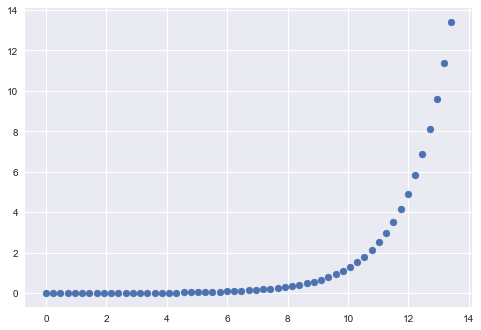

In [38]:
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kvec)
plt.show()

Grid of per-period flows:

In [42]:
# operating profits, op
op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kvec ** alpha_k) ** (1 / (1 - alpha_l))))

# firm cash flow, e
e = np.zeros((sizek, sizek))
for i in range(sizek):
    for j in range(sizek):
            e[i, j] = (op[i] - kvec[j] + ((1 - delta) * kvec[i]) -
                       ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                        / kvec[i]))

In [25]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

In [ ]:
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizek):
                Vmat[i, j] = e[i, j] + betafirm * V[j]
    Vstore[:, VFiter] = V.reshape(sizek,)  # store value function at each
    # iteration for graphing later
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1